# in silico ChIP at cell-type resolution

In [3]:
###################
## Load packages
###################
suppressPackageStartupMessages({
    library(scran)
    library(scater)
})
source('../insilico_chip/utils.R')

In [4]:
###################
## I/O
###################
io = list()
io$basedir = '/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/'

## All celltype pseudobulk
io$RNA_sce = file.path(io$basedir, '/results/rna/pseudobulk/celltype/SingleCellExperiment_pseudobulk.rds')
io$ATAC_sce = file.path(io$basedir, '/results/atac/archR/pseudobulk/celltype/PeakMatrix/pseudobulk_PeakMatrix_summarized_experiment.rds')

#
io$motifmatcher <- file.path(io$basedir, "data/processed/atac/archR/Annotations/CISBP-Scores.rds")
io$motif2gene <- file.path(io$basedir, "data/processed/atac/archR/Annotations/CISBP_motif2gene.txt.gz")
io$background_peaks = file.path(io$basedir,"/data/processed/atac/archR/Background-Peaks.rds")


In [5]:
#######################
## Load RNA and ATAC 
#######################

# Load SingleCellExperiment
rna.sce <- readRDS(io$RNA_sce)

# Load ATAC SummarizedExperiment
atac.sce <- readRDS(io$ATAC_sce)

# Normalise ATAC data
assayNames(atac.sce) <- "counts"
assay(atac.sce,"logcounts") <- log(1e6*(sweep(assay(atac.sce),2,colSums(assay(atac.sce),na.rm=T),"/"))+1)

# Make sure that samples are consistent
samples <- intersect(colnames(rna.sce),colnames(atac.sce))
rna.sce <- rna.sce[,samples]
atac.sce <- atac.sce[,samples]

print(sprintf("Number of celltypes: %s",length(samples)))

[1] "Number of celltypes: 37"


In [6]:
# RNA dimreduction

decomp <- modelGeneVar(rna.sce)
decomp <- decomp[decomp$mean > 0.01,]
hvgs <- decomp[order(decomp$FDR),] %>% head(n=2000) %>% rownames

sce_filt <- rna.sce[hvgs,]
sce_filt <- runPCA(sce_filt, ncomponents = 20, ntop=2000)

Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”


In [7]:
sce_filt <- runUMAP(sce_filt, dimred="PCA", n_neighbors = 20, min_dist = 1.5)

umap.dt <- reducedDim(sce_filt,"UMAP") %>% as.data.table %>% 
  .[,cell:=colnames(sce_filt)] %>%
  setnames(c("UMAP1","UMAP2","cell"))

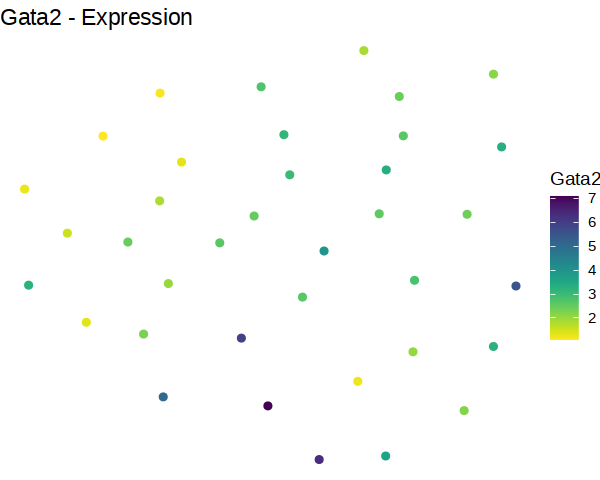

In [8]:
options(repr.plot.width=5, repr.plot.height=4)
gene = 'Gata2'
ggplot(umap.dt, aes(UMAP1, UMAP2, col=as.vector(assay(rna.sce[gene,], 'logcounts')))) + 
    geom_point() +
    viridis::scale_color_viridis(begin=1, end=0, name=gene) + 
    ggtitle(paste0(gene, ' - Expression')) + 
    theme_void()

In [10]:
#######################
## Load Motifs if wanted
#######################
motifmatcher.se <- readRDS(io$motifmatcher)

# Subset peaks
stopifnot(sort(rownames(motifmatcher.se))==sort(rownames(atac.sce)))
motifmatcher.se <- motifmatcher.se[rownames(atac.sce),]

motif2gene.dt <- fread(io$motif2gene)

In [11]:
###################
## Correlate TF-expr & Region-accessibility
###################  
a = Sys.time()
tf2peak_cor.se = cor_TF_acc(rna.sce, 
                          atac.sce, 
                          TFs_filt = NULL,  # c('SOX17', 'MYBL1') -> test runs
                          motifmatcher.se = motifmatcher.se, 
                          motif2gene.dt = motif2gene.dt,
                          correlation_method = "pearson", 
                          remove_motifs = c("T_789"))
b = Sys.time()
b-a

[1] "Removing 0 TFs that have duplicated gene-motif pairs:\n"


Correlate TF-expr & Region-accessibility for 738 TFs



Time difference of 49.24039 secs

In [12]:
######################################
## Create virtual chip-seq library 
######################################
a = Sys.time()
motifmatcher_chip = silico_chip(atac.sce = atac.sce, 
                           tf2peak_cor.se = tf2peak_cor.se,
                           motifmatcher.se = motifmatcher.se,
                           motif2gene.dt = motif2gene.dt, 
                           min_number_peaks = 50,
                           TFs_filt = NULL, 
                           remove_motifs = c("T_789"),
                           cores = detectCores())

motifmatcher_chip.se = motifmatcher_chip$motifmatcher_chip.se
virtual_chip.dt = motifmatcher_chip$virtual_chip.dt
b = Sys.time()
b-a

[1] "Number of peaks: 192251"
[1] "Predicting TF binding sites..."
[1] "Number of TFs: 738"
[1] "Updating motifmatchr results using the virtual ChIP-seq library..."


Time difference of 30.21372 secs

In [13]:
######################################
## silico_chipseq_validation
######################################
library(GenomicRanges)
library(rtracklayer)

io$chip_dir.prefix <- "/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/results/revisions/chip_files"
io$chip.files <- c(
  "CDX2" = file.path(io$chip_dir.prefix, "GSM2253707_Cdx2_wtEpiSCs_24h_rep1_mm10.bw"),
  "TAL1" = file.path(io$chip_dir.prefix, "GSM1692858_HP_Tal1.bw"),
  "GATA1" = file.path(io$chip_dir.prefix, "GSM1692851_HP_Gata1.bw"),
  "FOXA2" = file.path(io$chip_dir.prefix, "Foxa2.d5FS.bw"),
  "GATA4" = file.path(io$chip_dir.prefix, "GSM3223330_Gata4.d5FS.r1_m1.ucsc.bigWig"),
  "TBX5" = file.path(io$chip_dir.prefix, "Tbx5_WT_CP.bw")
)
peak_metadata.gr = makeGRangesFromDataFrame(rowData(atac.sce))
stopifnot(file.exists(io$chip.files))
TFs <- names(io$chip.files)

## calculate background ChIP signal 
chip_background.dt <- mclapply(TFs, function(i) {
  data.table(
    chip_anno = i,
    median = median(import.bw(BigWigFile(io$chip.files[[i]]))$score)
  )
}, mc.cores=10) %>% rbindlist

## calculate signal 
peak_metadata_ucsc.gr <- peak_metadata.gr; seqlevelsStyle(peak_metadata_ucsc.gr) <- 'UCSC'
peak_metadata_ncbi.gr <- peak_metadata.gr; seqlevelsStyle(peak_metadata_ncbi.gr) <- 'NCBI'
tf2seqstyle <- rep("UCSC",length(TFs)); names(tf2seqstyle) <- TFs
tf2seqstyle["TBX5"] <- "NCBI"

to.plot <- mclapply(TFs, function(i){
  # Load virtual ChIP-seq library
    virtual_chip_tmp = copy(virtual_chip.dt)[tf==i] %>% 
        setnames('peak', 'idx') %>% 
        .[,idx:=str_replace(idx,":","-")] %>%
        .[,chr:=strsplit(idx,"-") %>% map_chr(1)] %>%
        .[,start:=as.integer(strsplit(idx,"-") %>% map_chr(2))] %>%
        .[,end:=as.integer(strsplit(idx,"-") %>% map_chr(3))] %>%
        .[,idx:=str_replace(idx,"-",":")] %>% 
        setkey(chr,start,end)

    # Load ground truth ChIP-seq data
    if (tf2seqstyle[[i]]=="UCSC") {
        tmp <- peak_metadata_ucsc.gr
    } else if (tf2seqstyle[[i]]=="NCBI") {
        tmp <- peak_metadata_ncbi.gr
    }

    chip.dt <- import.bw(BigWigFile(io$chip.files[[i]]), selection = tmp) %>% as.data.table %>%
        .[,c(1,2,3,6)] %>% setnames(c("chr", "start", "end","value")) %>%
        .[,chr:=as.character(chr)] %>%
        .[,chr:=ifelse(grepl("chr",chr),chr,paste0("chr",chr))] %>%
      setkey(chr,start,end)

      # overlap ATAC peaks with ChIP-seq signal and quantify ChIP signal
    to.plot =  virtual_chip_tmp[,c("idx","chr","start","end")] %>%
        foverlaps(chip.dt, nomatch=0) %>% 
        .[,.(value=sum(value)), b=c("idx")] %>%
        merge(virtual_chip_tmp[,c("idx","score","motif_score", "max_accessibility_score")]) %>%
        .[,chip_anno:=as.factor(i)] %>%
        return
  
}, mc.cores=10) %>% rbindlist

seq.ranges <- seq(0,1,by=0.10); names(seq.ranges) <- as.character(1:length(seq.ranges))

foo <- to.plot %>%
  .[score>=0] %>% 
  merge(chip_background.dt,by="chip_anno") %>%
  .[,log_value:=log(value+1)] %>%
  .[,c("chip_anno","idx","log_value","motif_score","score", "max_accessibility_score")] %>%
  setnames("score","score_rna_atac")

to.plot.compare_models <- foo %>%
  # Model 1: DNA
  # .[,score_dna:=minmax.normalisation(motif_score), by="chip_anno"] %>% 
  # Model 2: DNA + ATAC
  .[,score_dna_atac:=minmax.normalisation(max_accessibility_score * motif_score), by="chip_anno"] %>% .[,score_dna_atac:=score_dna_atac+0.001] %>%
  # Model 3: DNA + ATAC + RNA
  .[,score_rna_atac:=minmax.normalisation(score_rna_atac), by="chip_anno"] %>% .[,score_rna_atac:=score_rna_atac+0.001] %>%
  # Discretise values
  # .[,score_dna_group:=cut(abs(score_dna), breaks=seq.ranges)] %>% .[,score_dna_group:=seq.ranges[as.numeric(score_dna_group)]] %>%
  .[,score_dna_atac_group:=cut(abs(score_dna_atac), breaks=seq.ranges)] %>% .[,score_dna_atac_group:=seq.ranges[as.numeric(score_dna_atac_group)]] %>%
  .[,score_rna_atac_group:=cut(abs(score_rna_atac), breaks=seq.ranges)] %>% .[,score_rna_atac_group:=seq.ranges[as.numeric(score_rna_atac_group)]] %>%
  # Prepare for plotting
  melt(id.vars=c("chip_anno","idx","log_value"), measure.vars=c("score_dna_atac_group","score_rna_atac_group"), variable.name="model", value.name="predicted_value") %>%
  .[,N:=.N,by=c("model","chip_anno","predicted_value")] %>%
  .[,.(mean=mean(log_value,na.rm=T), sd=sd(log_value,na.rm=T), N=.N), by=c("model","chip_anno","predicted_value")] %>%
  # Filter settings with a small number of observations
  .[!is.na(mean) & N>=25]

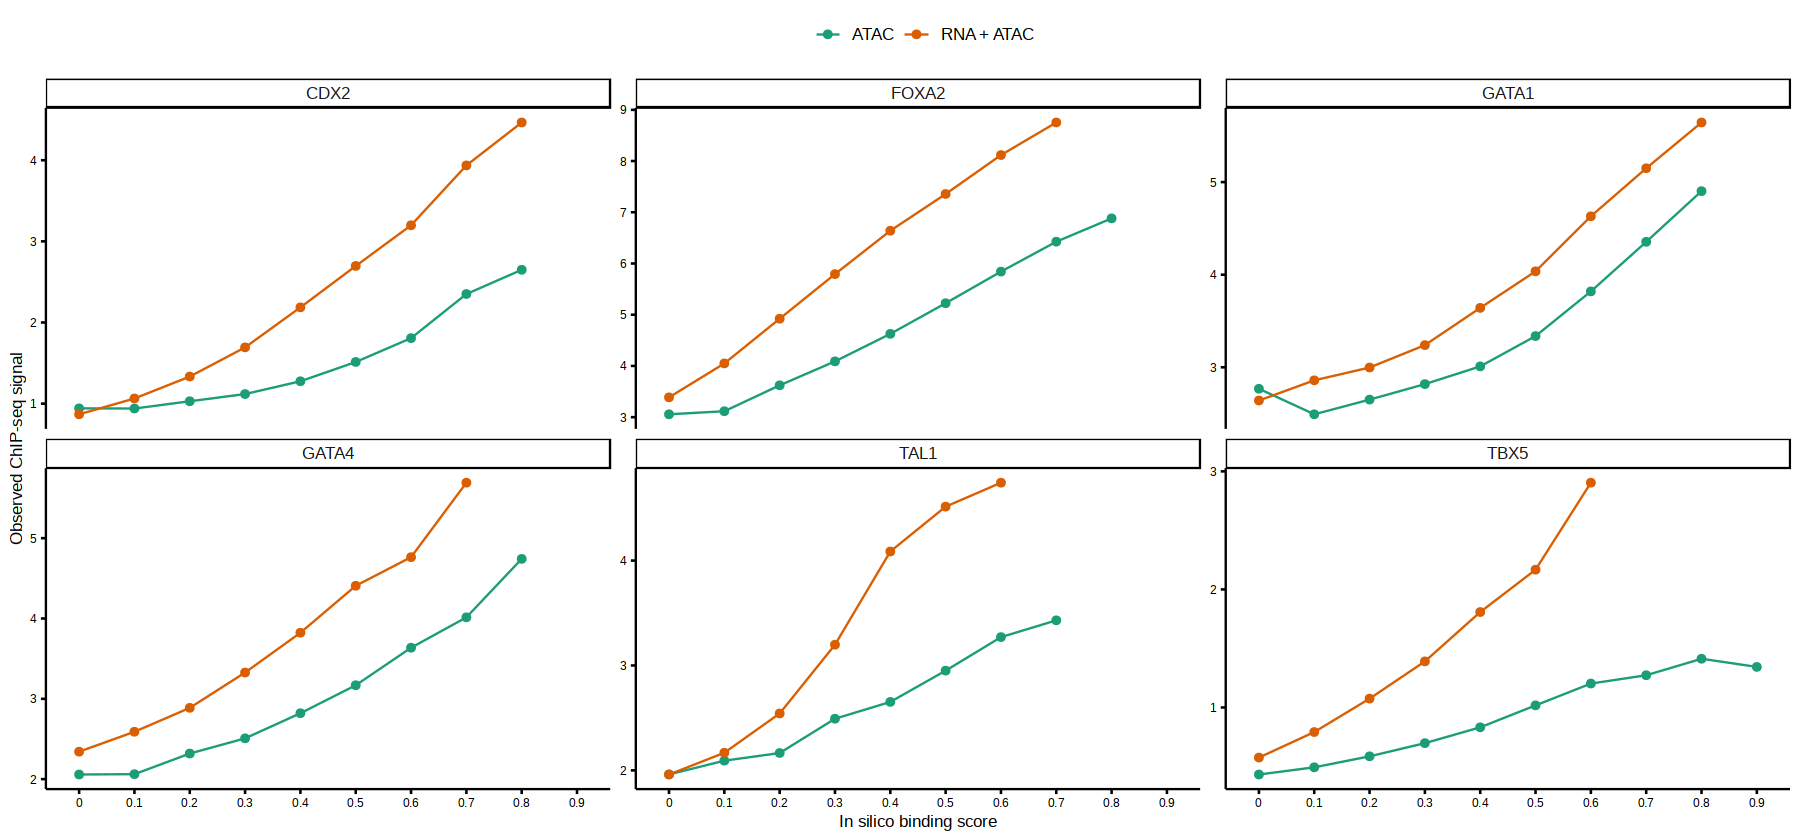

In [14]:
options(repr.plot.width=15, repr.plot.height=7)
ggline(to.plot.compare_models, x="predicted_value", y="mean", color="model", plot_type="b") +
  facet_wrap(~chip_anno, scales="free_y") +
  # geom_errorbar(aes(ymin=log_value-sd, ymax=log_value-sd), width=.2,) +
  scale_color_brewer(palette="Dark2", labels = c("ATAC", "RNA + ATAC")) +
  # scale_color_discrete(labels = c("DNA", "DNA + ATAC", "DNA + ATAC + RNA")) +
  labs(y="Observed ChIP-seq signal", x="In silico binding score") +
  theme(
    strip.background = element_rect(colour="black", fill=NA),
    axis.text = element_text(size=rel(0.55)),
    axis.title = element_text(size=rel(0.8)),
    legend.title = element_blank(),
    # legend.position = c(.26,.87)
    # legend.position = c(.06,.94)
    legend.position = "top"
  )